In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# In this notebook, I'll be using Random Forest Classifier on the famous Titanic Dataset.

**Exploratory Data Analysis**

In this section, we'll try to comprehend the data so that we can figure what we have to do in feature engineering section.

In [2]:
# Importing necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt # For visualization 
import seaborn as sns # For visualization


In [3]:
# Import the dataset
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [4]:
# Printing the summary of dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* 5   Age          714 non-null 
* 10  Cabin        204 non-null
* 11  Embarked     889 non-null 


**** The above description shows that these three features have null values****

**Survived**

In [5]:
# Checking how many people survived as per the dataset
train['Survived'].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Around 39% of people survived.

<AxesSubplot:xlabel='Survived', ylabel='count'>

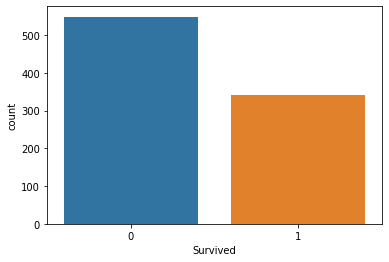

In [6]:
#Let's visualize this
sns.countplot(x = 'Survived', data = train)

**Does passenger class has anything to do with Survival? Let's find out!**

In [7]:
train['Survived'].groupby(train['Pclass']).value_counts(normalize = True)

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64

*It does have!!!!*

<AxesSubplot:xlabel='Pclass', ylabel='count'>

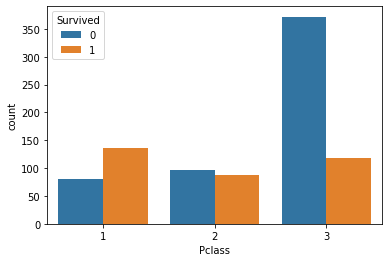

In [8]:
#Let's visualize
sns.countplot(x = 'Pclass', data = train, hue = 'Survived')

*Class 1 has the highest survival rate.*

**Name**

Let's exlore name column now.

In [9]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

I don't think so that `Name` column can be any useful. But, we can extract useful information out of it.

In [10]:
# Separating out the title
train['Name_Title'] = train['Name'].apply(lambda x : x.split(',')[1]).apply(lambda x: x.split()[0])
train['Name_Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Name_Title, dtype: int64

In [11]:
# Checking the survival rate for new variable
train['Survived'].groupby(train['Name_Title']).mean()

Name_Title
Capt.        0.000000
Col.         0.500000
Don.         0.000000
Dr.          0.428571
Jonkheer.    0.000000
Lady.        1.000000
Major.       0.500000
Master.      0.575000
Miss.        0.697802
Mlle.        1.000000
Mme.         1.000000
Mr.          0.156673
Mrs.         0.792000
Ms.          1.000000
Rev.         0.000000
Sir.         1.000000
the          1.000000
Name: Survived, dtype: float64

I belive that the above variable will be useful for our model, since the survial rate appears to be either significantly above or below the average survival rate.

Additionally, we'll be looking any relationship between the length of a name and survival_rate.

In [12]:
train['Name_Len'] = train['Name'].apply(lambda x : len(x))
train['Survived'].groupby(pd.qcut(train['Name_Len'],5)).mean()


Name_Len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

Interesting....there seems to be clear relationship between length of name and survival_rate.Why do people with long name have high survival rate? Are people with long names are more important, and that's why more likely to be prioritized in a shipwreck?

**Sex**

Let's analyze the Sex column. In any disaster, "Womens and Children are saved first". So, there should be high rate of survival among female.

In [13]:
train['Sex'].value_counts(normalize = True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [14]:
train['Survived'].groupby(train['Sex']).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

As expected, female has high survival rate.

**Age**

In [15]:
#Age is not null
train['Survived'].groupby(train['Age'].notnull()).mean()

Age
False    0.293785
True     0.406162
Name: Survived, dtype: float64

In [16]:
#Age is null
train['Survived'].groupby(train['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

Age with null has 10% lower survival rate than non-nulls.

In [17]:
train['Survived'].groupby(pd.qcut(train['Age'],5)).mean()

Age
(0.419, 19.0]    0.481707
(19.0, 25.0]     0.328467
(25.0, 31.8]     0.393701
(31.8, 41.0]     0.437500
(41.0, 80.0]     0.373239
Name: Survived, dtype: float64

In [18]:
pd.qcut(train['Age'],5).value_counts()

(0.419, 19.0]    164
(31.8, 41.0]     144
(41.0, 80.0]     142
(19.0, 25.0]     137
(25.0, 31.8]     127
Name: Age, dtype: int64

**SibSp**

SibSp column represents Number of siblings / spouses aboard the Titanic.

I don't think so it will be a strong predictor. Let's find out.

In [19]:
train['Survived'].groupby(train['SibSp']).mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [20]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

**Parch**

Parch represents Number of parents / children abroad the Titanic

In [21]:
train['Survived'].groupby(train['Parch']).mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [22]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

It is also a weak predictor.

**Ticket**

Let's explore the Ticket feature

In [23]:
train['Ticket'].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

One piece of potentially useful informatin is the number of characters in the Ticket column. This could be a reflection of the 'type' of ticket a given passenger had, which could somehow indicate their chances of survival. One theory (which may in fact be verifiable) is that some characteristic of the ticket could indicate the location of the passenger's room, which might be a crucial factor in their escape route, and consequently their survival.

In [24]:
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))

In [25]:
train['Ticket_Len'].value_counts()

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

Another piece of information is the first letter of each ticket, which, again, might be indicative of a certain attribute of the ticketholders or their rooms.



In [26]:
train['Ticket_Lett'] = train['Ticket'].apply(lambda x: str(x)[0])

In [27]:
train['Ticket_Lett'].value_counts()

3    301
2    183
1    146
P     65
S     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Lett, dtype: int64

In [28]:
train['Survived'].groupby(train['Ticket_Lett']).mean()

Ticket_Lett
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

**Fare**

I am hoping that there will be strong relationship between `Fare` and `Survived`.A similar to `class` and `Survived`.

In [29]:
pd.qcut(train['Fare'],3).value_counts()

(-0.001, 8.662]    308
(26.0, 512.329]    295
(8.662, 26.0]      288
Name: Fare, dtype: int64

In [30]:
train['Survived'].groupby(pd.qcut(train['Fare'],3)).mean()

Fare
(-0.001, 8.662]    0.198052
(8.662, 26.0]      0.402778
(26.0, 512.329]    0.559322
Name: Survived, dtype: float64

**Cabin**

This column has the most nulls (almost 700), but we can still extract information from it, like the first letter of each cabin, or the cabin number. The usefulness of this column might be similar to that of the `Ticket` variable.

*Cabin Letter*

In [31]:
train['Cabin_Letter'] = train['Cabin'].apply(lambda x: str(x)[0])

In [32]:
train['Cabin_Letter'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

In [33]:
train['Survived'].groupby(train['Cabin_Letter']).mean()

Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

> We can see that most of the cabin letters are associated with a high survival rate, so this might very well be a useful variable.

*Cabin Number*
> Upon first glance, this appears to be useless. Not only do we have ~700 nulls which will be difficult to impute, but the correlation with Survived is almost zero. However, the cabin numbers as a whole do seem to have a high surival rate compared to the population average, so we might want to keep this just in case for now.

In [34]:
train['Cabin_num'] = train['Cabin'].apply(lambda x : str(x).split(' ')[-1][1:])
train['Cabin_num'].replace('an', np.NaN, inplace = True)
train['Cabin_num'] = train['Cabin_num'].apply(lambda x : int(x) if not pd.isnull(x) and x != '' else np.NaN)

In [35]:
pd.qcut(train['Cabin_num'],3).value_counts()

(1.999, 28.667]     67
(65.667, 148.0]     67
(28.667, 65.667]    66
Name: Cabin_num, dtype: int64

In [36]:
train['Survived'].groupby(pd.qcut(train['Cabin_num'],3)).mean()

Cabin_num
(1.999, 28.667]     0.716418
(28.667, 65.667]    0.651515
(65.667, 148.0]     0.641791
Name: Survived, dtype: float64

In [37]:
train['Survived'].corr(train['Cabin_num'])

-0.06384595922789371

**Embarked**

This column represent the Port of Embarkation. There are three ports Cherbourg (represented by 'C'), Queenstown (represented by 'Q') and Southampton (represented by 'S'). 
> Let's find out this variable relationship with `Survived`

In [38]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [39]:
train['Embarked'].value_counts(normalize = True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [40]:
train['Survived'].groupby(train['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

*It looks like that the passengers who embarked from Cherbourg have high survival rate.*

**Feature Engineering**

Having explored the variables, we have a good understanding of how we want to transform our variable in preparation for our final dataset. We will perform feature engineering through series of helper functions that each serve a specific purpose.

In [41]:
def names(train,test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x : len(x))
        i['Name_Title'] = i['Name'].apply(lambda x : x.split(',')[1]).apply(lambda x : x.split()[0])
        del i['Name']
    return train, test

Next, we impute the null values of `Age` column by filling in the mean value of the passenger's corresponding title and class. I'll be taking more granular approach hoping that it will be more accuarte than simply taking mean age of the population.

In [42]:
def age_impute(train,test):
    for i in [train,test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title','Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train,test

Both `Sibsp` and `Parch` are weak predictors. But we can combine them to crate a new variable that will indicate family size. 

In [43]:
def fam_size(train,test):
    for i in [train,test]:
        i['Fam_Size'] = np.where((i['SibSp'] + i['Parch']) == 0, 'Solo',
                                 np.where((i['SibSp'] + i['Parch']) <= 3, 'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train,test

The `Ticket` column is used to create two new columns: `Ticket_Lett`, which indicates the first letter of each ticket (with the smaller-n values being grouped based on survival rate); and `Ticket_Len`, which indicates the length of the `Ticket` field. 

In [44]:
def ticket_grouped(train,test):
    for i in [train,test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x : str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x : str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1','2','3','S','P','C','A']),i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W','4','7','6','L','5','8']),
                                   'Low_ticket','Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x : len(x))
        del i['Ticket']
    return train,test

The following two functions extract the first letter of `Cabin` columns and its number, respectively.

In [45]:
def cabin(train,test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x : str(x)[0])
        del i['Cabin']
    return train,test

In [46]:
def cabin_num(train,test):
    for i in [train,test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x : str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an',np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x : int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train,test


Now, we will fill the null values in `Embarked` column with the most commonly occuring value i.e 'S'.


In [47]:
def embarked_impute(train,test):
    for i in [train,test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train,test

We also fill in the one missing value of `Fare` in our dataset_test set with the mean from our dataset (training set).
****Note****: Transformations of test set data must always be fit using training data.

In [48]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

Now, we need to convert our categorical columns into dummy variable because we are using scikit-learn. The below function does this, and then it drops the original categorical columns. It also makes sure that each category is present in both training and testing datasets.

In [49]:
def dummies(train, test, columns = ['Pclass','Sex','Embarked', 'Ticket_Lett','Cabin_Letter','Name_Title','Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x : str(x))
        test[column] = test[column].apply(lambda x : str(x))
        good_cols = [column + '_' + i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train,pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test
        

Our last helper function drops any column that haven't already been dropped. In our case, we only need to drop the `Passenger_Id` column, which we have decided is not useful for our model.

In [50]:
def drop(train, test, bye = ['PassengerId']):
    for i in [train,test]:
        for z in bye:
            del i[z]
    return train,test

Now, we can use our helper functions in order to build our dataset that will be used in modelling.

In [51]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
train, test = names(train, test)
train, test = age_impute(train, test)
train, test = cabin_num(train,test)
train, test = cabin(train, test)
train, test = embarked_impute(train,test)
train,test = fam_size(train,test)
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
train, test = ticket_grouped(train,test)
train, test = dummies(train, test, columns = ['Pclass','Sex','Embarked','Ticket_Lett','Cabin_Letter','Name_Title','Fam_Size'])
train, test = drop(train, test)


We can see that our final dataset has 45 columns, composed of our target column and 44 predictor variables.

In [52]:
print(len(train.columns))

45


**Hyperparameter Training**

> I'll be using grid search to identify th optimal parameters of our random forest model. Because our training data is quite small, we can 
get away with testing a wider range of hyperparameter values.

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_features = 'auto',oob_score = True, random_state = 1, n_jobs = -1)

param_grid = {'criterion' : ["gini","entropy"], "min_samples_leaf" : [1,5,10],"min_samples_split" : [2,4,10,12,16], 
             "n_estimators" : [50, 100, 400, 700, 1000]}

gs = GridSearchCV(estimator = classifier, param_grid = param_grid, scoring = 'accuracy', cv = 3, n_jobs = -1)

gs.fit(train.iloc[:,1:], train.iloc[:,0])

print(gs.best_score_)
print(gs.best_params_)
print(gs.cv_results_)


0.8383838383838383
{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 700}
{'mean_fit_time': array([0.35569572, 0.51627469, 1.97648231, 3.27726801, 4.59401043,
       0.29115804, 0.52967111, 1.82720558, 3.04987335, 4.41097585,
       0.30266015, 0.48671627, 1.7679708 , 3.03898271, 4.33186173,
       0.30169749, 0.49703471, 1.67496729, 2.94572719, 4.45393976,
       0.30457815, 0.56985466, 1.9147199 , 3.03503505, 4.4104859 ,
       0.30621004, 0.48157438, 1.74211033, 2.93582702, 4.30287019,
       0.30708297, 0.48834332, 1.70478225, 2.96628706, 4.22019776,
       0.30693038, 0.4862628 , 1.65382735, 2.84764695, 4.47556353,
       0.30247887, 0.61828581, 1.91035763, 3.12281688, 4.59971523,
       0.31412514, 0.4953053 , 1.82777945, 2.98101187, 4.30975533,
       0.29963923, 0.48791242, 1.71331724, 2.95977632, 4.33841499,
       0.31419651, 0.49026306, 1.76139506, 2.94144853, 4.510372  ,
       0.30321995, 0.65248561, 1.70236484, 2.94928153, 4.27907705,
 

We had used n_jobs = -1, so that model use all the available cores. And used random_state = 1 to get the same results.

*We can see that our optimal parameter settings are not at the endpoints of our provided values, meaning that we don't
have to test more values.*

**Model Estimation and Evaluation**

We can fit our model using hyperparameters. The out-of-bag score can give us an unbiased estimate of the model accuracy.

In [54]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(criterion = 'gini', 
                           n_estimators = 700,
                           min_samples_split = 10,
                           min_samples_leaf = 1,
                           max_features = 'auto',
                           oob_score = True,
                           random_state = 1,
                           n_jobs = -1)
RF.fit(train.iloc[:,1:], train.iloc[:,0])
print(RF.oob_score_)

0.8294051627384961


Let's take a brief look at our variable importance according to our random forest model.

In [55]:
pd.concat((pd.DataFrame(train.iloc[:,1:].columns, columns = ['variable']),
          pd.DataFrame(RF.feature_importances_, columns = ['importance'])),
         axis = 1).sort_values(by = 'importance', ascending = False)[:20]

,variable,importance
12,Sex_female,0.111215
11,Sex_male,0.109769
33,Name_Title_Mr.,0.109746
1,Fare,0.088209
2,Name_Len,0.087904
0,Age,0.078651
8,Pclass_3,0.043268
35,Name_Title_Miss.,0.031292
7,Ticket_Len,0.031079
34,Name_Title_Mrs.,0.028852


Our last step is to predict the target variable for our test data.

In [56]:
predictions = RF.predict(test)
predictions = pd.DataFrame(predictions, columns = ['Survived'])
test = pd.read_csv('../input/titanic/test.csv')
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)


In [57]:
predictions

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


> My Inspiration : 
* https://www.kaggle.com/code/zlatankr/titanic-random-forest-82-78/data
* https://www.youtube.com/watch?v=J4Wdy0Wc_xQ
* https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
